In [79]:
import pandas as pd
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
%matplotlib inline
import logging
from importlib import reload
from src import embeddings_filter
from tqdm import tqdm
import collections
import json
import bz2

In [ ]:
# df = pd.io.json.read_json('data/data', lines=True,encoding='utf-8', encoding_errors='ignore')
# df.sample(10)
list_of_dict = []
k = 0
with bz2.open('data/cosine.json.bz2', 'rb') as s_file:
    while True:
        try:
            d =  json.loads(next(s_file))
            list_of_dict.append(d)
            k+=1
        except StopIteration:
            break

df = pd.DataFrame(list_of_dict)

In [ ]:
df.describe()

In [ ]:
df.sort_values(by='cosine_similarity',ascending=True).head(10)

In [ ]:
df[df.quantile(q=0.05)['cosine_similarity'] >df['cosine_similarity']].sample(15)

In [76]:
df[df.quantile(q=0.05)['cosine_similarity'] >df['cosine_similarity']].to_pickle('sample_data.pkl.zip')

## Preprocessing
We have the following stats for the preprocessing:
Finished initial Preprocessing
Total processed Quotes:  20874338
Of which no speaker:  7016300
Of which uncertain:  6560
Of which not tokenizable:  0
Total Quotes written:  13851478
avg similarity:  0.5109067554857766
median similarity:  0.4909448027610779

## Filtering
We load our pretrained fasttext model. We test the model by finding the closet terms to market.

In [2]:
# convenience for faster testing in notebook
reload(embeddings_filter)

model = embeddings_filter.load_embeddings(get_model=True)
model.get_nearest_neighbors('market')

[nltk_data] Downloading package stopwords to /home/simon/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/simon/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


[(0.950352668762207, 'marketq'),
 (0.9497827887535095, 'marketg'),
 (0.948558509349823, 'market6'),
 (0.9429478049278259, 'marketbymarket'),
 (0.9422717094421387, 'marketyet'),
 (0.9384009838104248, 'marketpric'),
 (0.9382206797599792, 'marketit'),
 (0.9377272725105286, 'onmarket'),
 (0.9374149441719055, 'marketgo'),
 (0.9372236728668213, 'marketsit')]

As we can see, they are almost synonyms as expected.

We define our keywords and setup functions to measure the similarity:

In [24]:
# setup
keywords = ['market','stocks', 'trade', 'bonds']
similarity = embeddings_filter.get_similarity_measure(keywords, model)
generator = embeddings_filter.data_gen()

PROBABILITY_THRESHOLD = 0.5

i = 0
speakers = collections.defaultdict(list)
for data in generator:
    # Ignore if speaker is uncertain or none
    if data['speaker'] == 'None' or float(data['probas'][0][1]) < PROBABILITY_THRESHOLD:
        continue
    score = similarity(data['quotation'])
    if score == 0:
        continue
    speakers[data['speaker']].append(similarity(data['quotation']))

    i += 1
    if i > 100000:
        break

Simiarity failed for:  to have all that.
Simiarity failed for:  is not what we're about.


In [25]:
for k in speakers:
    speakers[k] = sum(speakers[k])/len(speakers[k])

array([[<AxesSubplot:title={'center':'similarity'}>]], dtype=object)

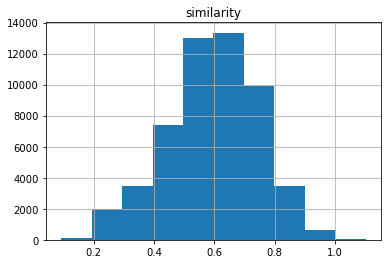

In [26]:
speakers_df = pd.DataFrame.from_dict(speakers, orient='index', columns=['similarity']).sort_values('similarity', ascending=False)
speakers_df.hist()